##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

# 图像分割

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-2348g60r
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-2348g60r
  Resolved https://github.com/tensorflow/examples.git to commit 3c7435733a9162481df350e57c53e58d2a705e4d
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1746868094.345130988853936603129253091149118257392589495885-py3-none-any.whl size=301646 sha256=3a2e7e5a86fa3f9806d3a0241785965fcf97374472809a07f3d579eb8521f844
  Stored in directory: /tmp/pip-ephem-wheel-cache-5_jbpk3b/wheels/91/9b/e8/6ae2ecc930bd726c578e35b313e987a687bc5ce03c3a42c2d5
Successfully built tensorflow-examples


In [ ]:
import tensorflow as tf
import os
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from tensorflow import TensorSpec

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)

# 輸入資料集路徑
#custom_dir = input("請貼上你的資料集資料夾完整路徑（如 /content/drive/MyDrive/...）：\n")

# 確認資料夾存在
# if not os.path.isdir(custom_dir):
#     raise FileNotFoundError(f"找不到資料夾：{custom_dir}，請確認路徑拼寫正確並已掛載雲端硬碟！")

#BASE_DIR = custom_dir
BASE_DIR = '/content/drive/MyDrive/ETT dataset'
print(f"資料夾設定成功：{BASE_DIR}")


# 超參數
IMG_SIZE   = 256
BATCH_SIZE = 16
AUTOTUNE   = tf.data.AUTOTUNE
NUM_CLASSES = 3
NUM_FOLDS  = 5

Mounted at /content/drive
Mounted at /content/drive
資料夾設定成功：/content/drive/MyDrive/ETT dataset


In [ ]:
# 圖片增強函數
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

augment_layer = Augment(seed=123)

In [ ]:
# 讀檔 + normalize
def load_and_normalize(image_path, mask_path):
  """
  讀取單張影像與遮罩
  img_path  : tf.string，影像檔路徑
  mask_path : tf.string，遮罩檔路徑
  return    : (image, mask)；image 為 float32、mask 為 int32
  """
  # 讀影像
  img = tf.io.read_file(image_path)
  img = tf.image.decode_png(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img = tf.cast(img, tf.float32) / 255.0

  # 讀遮罩（假設單通道 png，像素值=類別 ID）
  msk = tf.io.read_file(mask_path)
  msk = tf.image.decode_png(msk, channels=1)
  msk = tf.image.resize(msk, [IMG_SIZE, IMG_SIZE], method="nearest")
  msk = tf.cast(msk, tf.int32)  # 確保是整數型

  return img, msk

In [ ]:
def parse_image_mask(image_path, mask_path):
    # 圖片處理
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)           # RGB
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0               # 正規化到 [0,1]

    # 遮罩處理
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)             # 灰階單通道
    mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE])
    mask = tf.cast(mask, tf.float32) / 255.0

    # 將所有非 0 的 pixel 當作前景（氣管內管）
    mask = tf.where(mask > 0, 1.0, 0.0)    # 產生 0.0 / 1.0
    mask = tf.cast(mask, tf.float32)      # 確保 float32
    return image, mask


def augment(image, mask):
    mask = tf.cast(mask, tf.float32)  # 統一型別，跟 image 一樣
    stacked = tf.concat([image, mask], axis=-1)   # shape=(H,W,4)
    flipped = tf.image.random_flip_left_right(stacked)
    image_aug = flipped[..., :3]
    mask_aug  = flipped[..., 3:]
    return image_aug, mask_aug

def build_dataset(image_dir, mask_dir, augment_data=False):
    img_paths  = sorted([f"{image_dir}/{f}" for f in tf.io.gfile.listdir(image_dir)])
    mask_paths = sorted([f"{mask_dir}/{f}"  for f in tf.io.gfile.listdir(mask_dir)])

    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    ds = ds.map(lambda i, m: parse_image_mask(i, m), num_parallel_calls=AUTOTUNE)
    if augment_data:
        ds = ds.map(lambda i, m: augment(i, m), num_parallel_calls=AUTOTUNE)

    return ds

呈现数据集中的图像样本及其对应的掩码：

In [ ]:
def plot_batch(image_batch, mask_batch, count=3):
    for i in range(min(count, image_batch.shape[0])):
        image = image_batch[i]
        mask  = mask_batch[i]

        # 調整 image 的顯示格式
        image = tf.cast(image, tf.float32)
        if tf.reduce_max(image) <= 1.0:
            image = image * 255.0
        image = tf.clip_by_value(image, 0, 255)
        image = tf.cast(image, tf.uint8)

        # squeeze 掉 mask 的通道
        if mask.ndim == 3:
            mask = tf.squeeze(mask, axis=-1)

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))

        axs[0].imshow(image.numpy())
        axs[0].set_title("Image")

        axs[1].imshow(mask.numpy(), cmap='gray')
        axs[1].set_title("Ground Truth")

        axs[2].imshow(mask.numpy(), cmap='gray')
        axs[2].set_title("Prediction (test function)")

        for ax in axs:
            ax.axis("off")
        plt.tight_layout()
        plt.show()

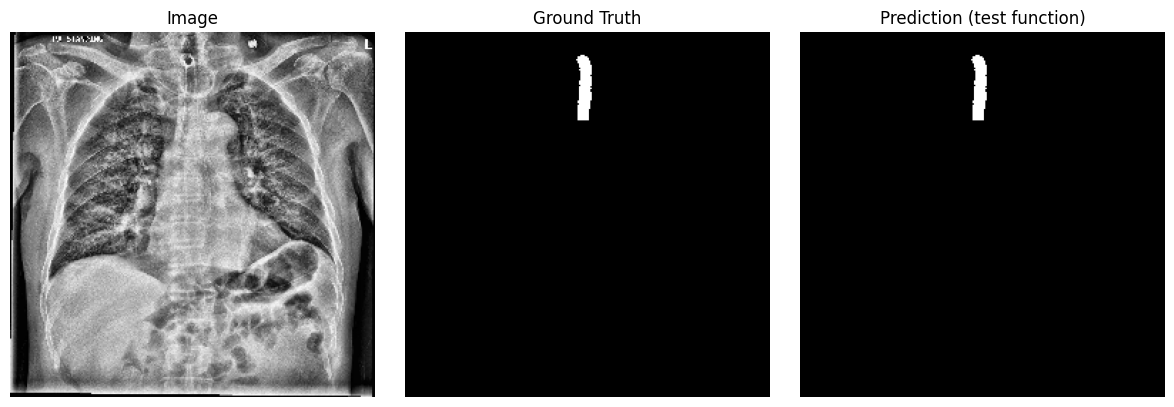

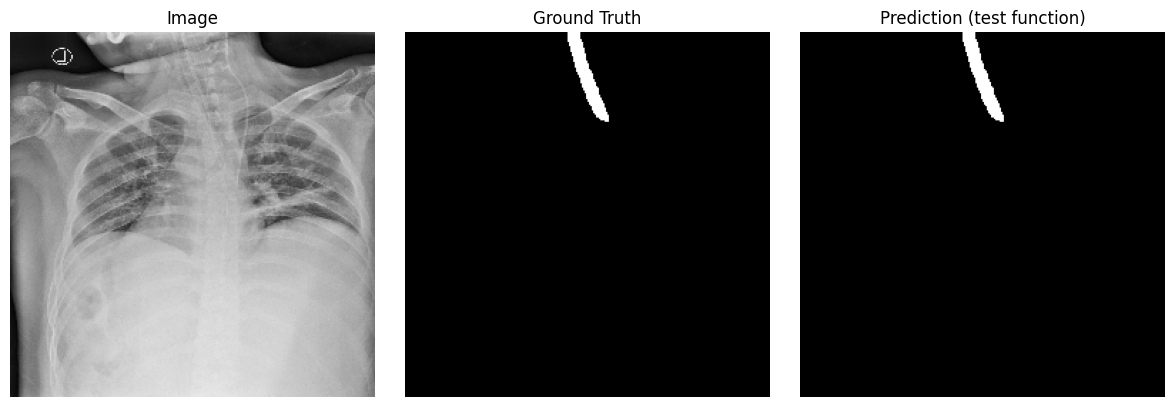

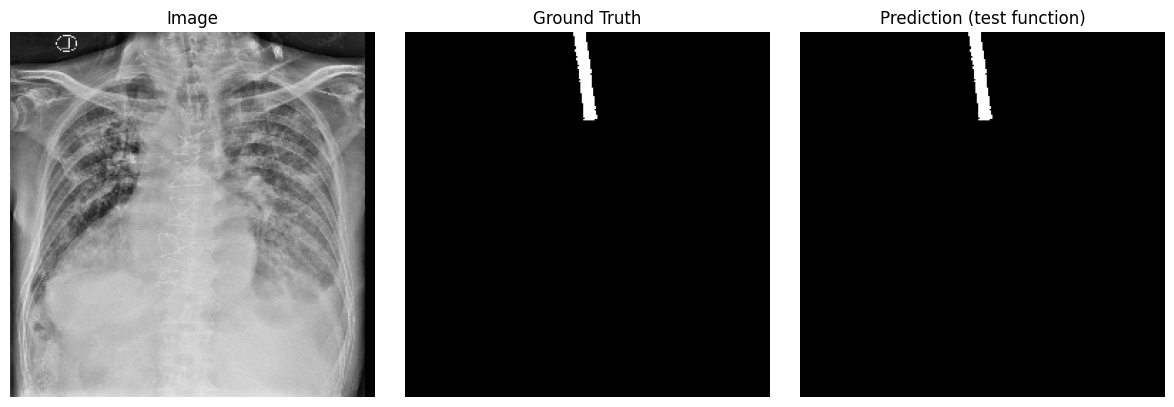

In [ ]:
train_ds= build_dataset(f"{BASE_DIR}/Fold{1}/train",
                             f"{BASE_DIR}/Fold{1}/trainannot",
                             augment_data=True).batch(BATCH_SIZE)
for image_batch, mask_batch in train_ds.take(1):  # 抓一個 batch
    plot_batch(image_batch, mask_batch, count=3)  # 顯示前三張圖

## 建立模型

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

<ipython-input-9-e7f2f656cbe8>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


解码器/上采样器只是在 TensorFlow 示例中实现的一系列上采样块：

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose

def fcn_model(input_shape=(256, 256, 3), num_classes=1):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # 使用 VGG16 的最後一層 feature map
    x = base_model.output

    # 加入卷積層（模仿 FCN head）
    x = Conv2D(4096, (7, 7), activation='relu', padding='same')(x)
    x = Conv2D(4096, (1, 1), activation='relu', padding='same')(x)

    # 預測類別數 (1 表示二分類)
    x = Conv2D(num_classes, (1, 1), activation=None, padding='same')(x)

    # 使用轉置卷積恢復到原始影像大小（上採樣 32 倍）
    x = Conv2DTranspose(num_classes, kernel_size=(64, 64), strides=(32, 32), padding='same', activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model


In [ ]:
def fcn_model(num_classes=NUM_CLASSES, base_filters=64):
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    # 補一層轉置卷積 回到原始解析度
    x = tf.keras.layers.Conv2DTranspose(
        base_filters, (3, 3), strides=2, padding='same'
    )(x)

    # 最後輸出 logits 通道數
    outputs = tf.keras.layers.Conv2D(
      1, (1, 1), activation='sigmoid', padding='same'
    )(x)


    return tf.keras.Model(inputs, outputs)

In [ ]:
# 全域宣告：1 公分 = 72 像素
P = 72.0

class MeanErrorCM(tf.keras.metrics.Metric):
    def __init__(self, name='mean_error_cm', **kwargs):
        super().__init__(name=name, **kwargs)
        self.total_error = self.add_weight(name='total_error', initializer='zeros')
        self.count       = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # 先把 y_true 轉成 float32
        y_true = tf.cast(y_true, y_pred.dtype)
        # 像素誤差 ÷ P → 公分誤差
        error_px = tf.abs(y_true - y_pred)
        error_cm = error_px / P
        self.total_error.assign_add(tf.reduce_sum(error_cm))
        self.count.assign_add(tf.cast(tf.size(error_cm), tf.float32))

    def result(self):
        return self.total_error / (self.count + 1e-8)

    def reset_states(self):
        self.total_error.assign(0.)
        self.count.assign(0.)


class AccuracyWithinThreshold(tf.keras.metrics.Metric):
    def __init__(self, threshold_cm=0.5, name='acc_within_threshold', **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold_cm = threshold_cm
        self.correct = self.add_weight(name='correct', initializer='zeros')
        self.total   = self.add_weight(name='total', initializer='zeros')

    def _extract_endpoint(self, mask):
      mask = tf.squeeze(mask, axis=-1)
      mask = tf.cast(mask, tf.float32)
      # 加入一個中繼張量，然後 cast 成 int32
      raw_indices = tf.where(mask > 0.5)
      indices     = tf.cast(raw_indices, tf.int32)

      def no_fg():
          return tf.constant([-1.0, -1.0], dtype=tf.float32)

      def has_fg():
          # indices[:,0] 代表 y 座標
          # output_type 直接指定為 tf.int32
          max_y_idx = tf.argmax(indices[:, 0], output_type=tf.int32)

          # 取出 (x, y) 並轉成 float32
          endpoint = tf.cast(indices[max_y_idx][::-1], tf.float32)
          return endpoint

      return tf.cond(tf.shape(indices)[0] == 0, no_fg, has_fg)


    def update_state(self, y_true, y_pred, sample_weight=None):
        def compute_sample_accuracy(args):
            gt_mask, pred_mask = args
            gt_point = self._extract_endpoint(gt_mask)
            pred_point = self._extract_endpoint(pred_mask)

            # 判斷是否為有效點（不是 [-1, -1]）
            is_valid = tf.reduce_all(gt_point >= 0) & tf.reduce_all(pred_point >= 0)

            def compute_accuracy():
                err_px = tf.norm(gt_point - pred_point)
                err_cm = err_px / P
                return tf.cast(err_cm <= self.threshold_cm, tf.float32)

            return tf.cond(is_valid, compute_accuracy, lambda: tf.constant(-1.0))  # 無效標記為 -1

        correctness_batch = tf.map_fn(
          compute_sample_accuracy,
          (y_true, y_pred),
          fn_output_signature=TensorSpec(shape=(), dtype=tf.float32)
        )

        # 過濾掉無效樣本（== -1）
        # 直接過濾出 >= 0 的項目
        valid_values = tf.boolean_mask(correctness_batch, correctness_batch >= 0.0)

        self.correct.assign_add(tf.reduce_sum(valid_values))
        self.total.assign_add(tf.cast(tf.shape(valid_values)[0], tf.float32))

    def result(self):
        return self.correct / (self.total + 1e-8)

    def reset_states(self):
        self.correct.assign(0.0)
        self.total.assign(0.0)

# 1. 建立一個 callback，專門拆 MeanIoU 的結果
class PerClassIoUCallback(tf.keras.callbacks.Callback):
    def __init__(self, mean_iou_metric):
        super().__init__()
        self.mean_iou = mean_iou_metric

    def on_epoch_begin(self, epoch, logs=None):
      # 清掉上一次累積的 confusion matrix
      self.mean_iou.reset_state()


    def on_epoch_end(self, epoch, logs=None):
        conf_matrix = self.mean_iou.total_cm.numpy()
        inter      = np.diag(conf_matrix)            # [conf[0,0], conf[1,1]]
        gt_sum     = conf_matrix.sum(axis=1)          # 每行：真實各類總數
        pred_sum   = conf_matrix.sum(axis=0)          # 每列：預測各類總數
        union      = gt_sum + pred_sum - inter
        per_iou    = inter / (union + 1e-8)

        print(f"\nEpoch {epoch+1} per-class IoU:")
        print(f"  - 背景 (0) IoU: {per_iou[0]:.4f}")
        print(f"  - 前景 (1) IoU: {per_iou[1]:.4f}")

In [ ]:
class BinarizedIoU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.int32)
        y_true = tf.cast(y_true, tf.int32)
        return super().update_state(y_true, y_pred, sample_weight)

In [ ]:
OUTPUT_CLASSES = 2

model = fcn_model()
# 定義 MeanIoU、平均誤差公分、誤差在0.5cm內準確率、誤差在1.0cm內準確率
iou_metric = BinarizedIoU(num_classes=2, name='mean_iou')
mean_error = MeanErrorCM(name='mean_error_cm')
acc_0_5cm = AccuracyWithinThreshold(0.5, name='acc_within_0.5cm')
acc_1_0cm = AccuracyWithinThreshold(1.0, name='acc_within_1.0cm')

metrics   = [iou_metric, mean_error, acc_0_5cm, acc_1_0cm]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=metrics,
    run_eagerly=True
)

绘制最终的模型架构：

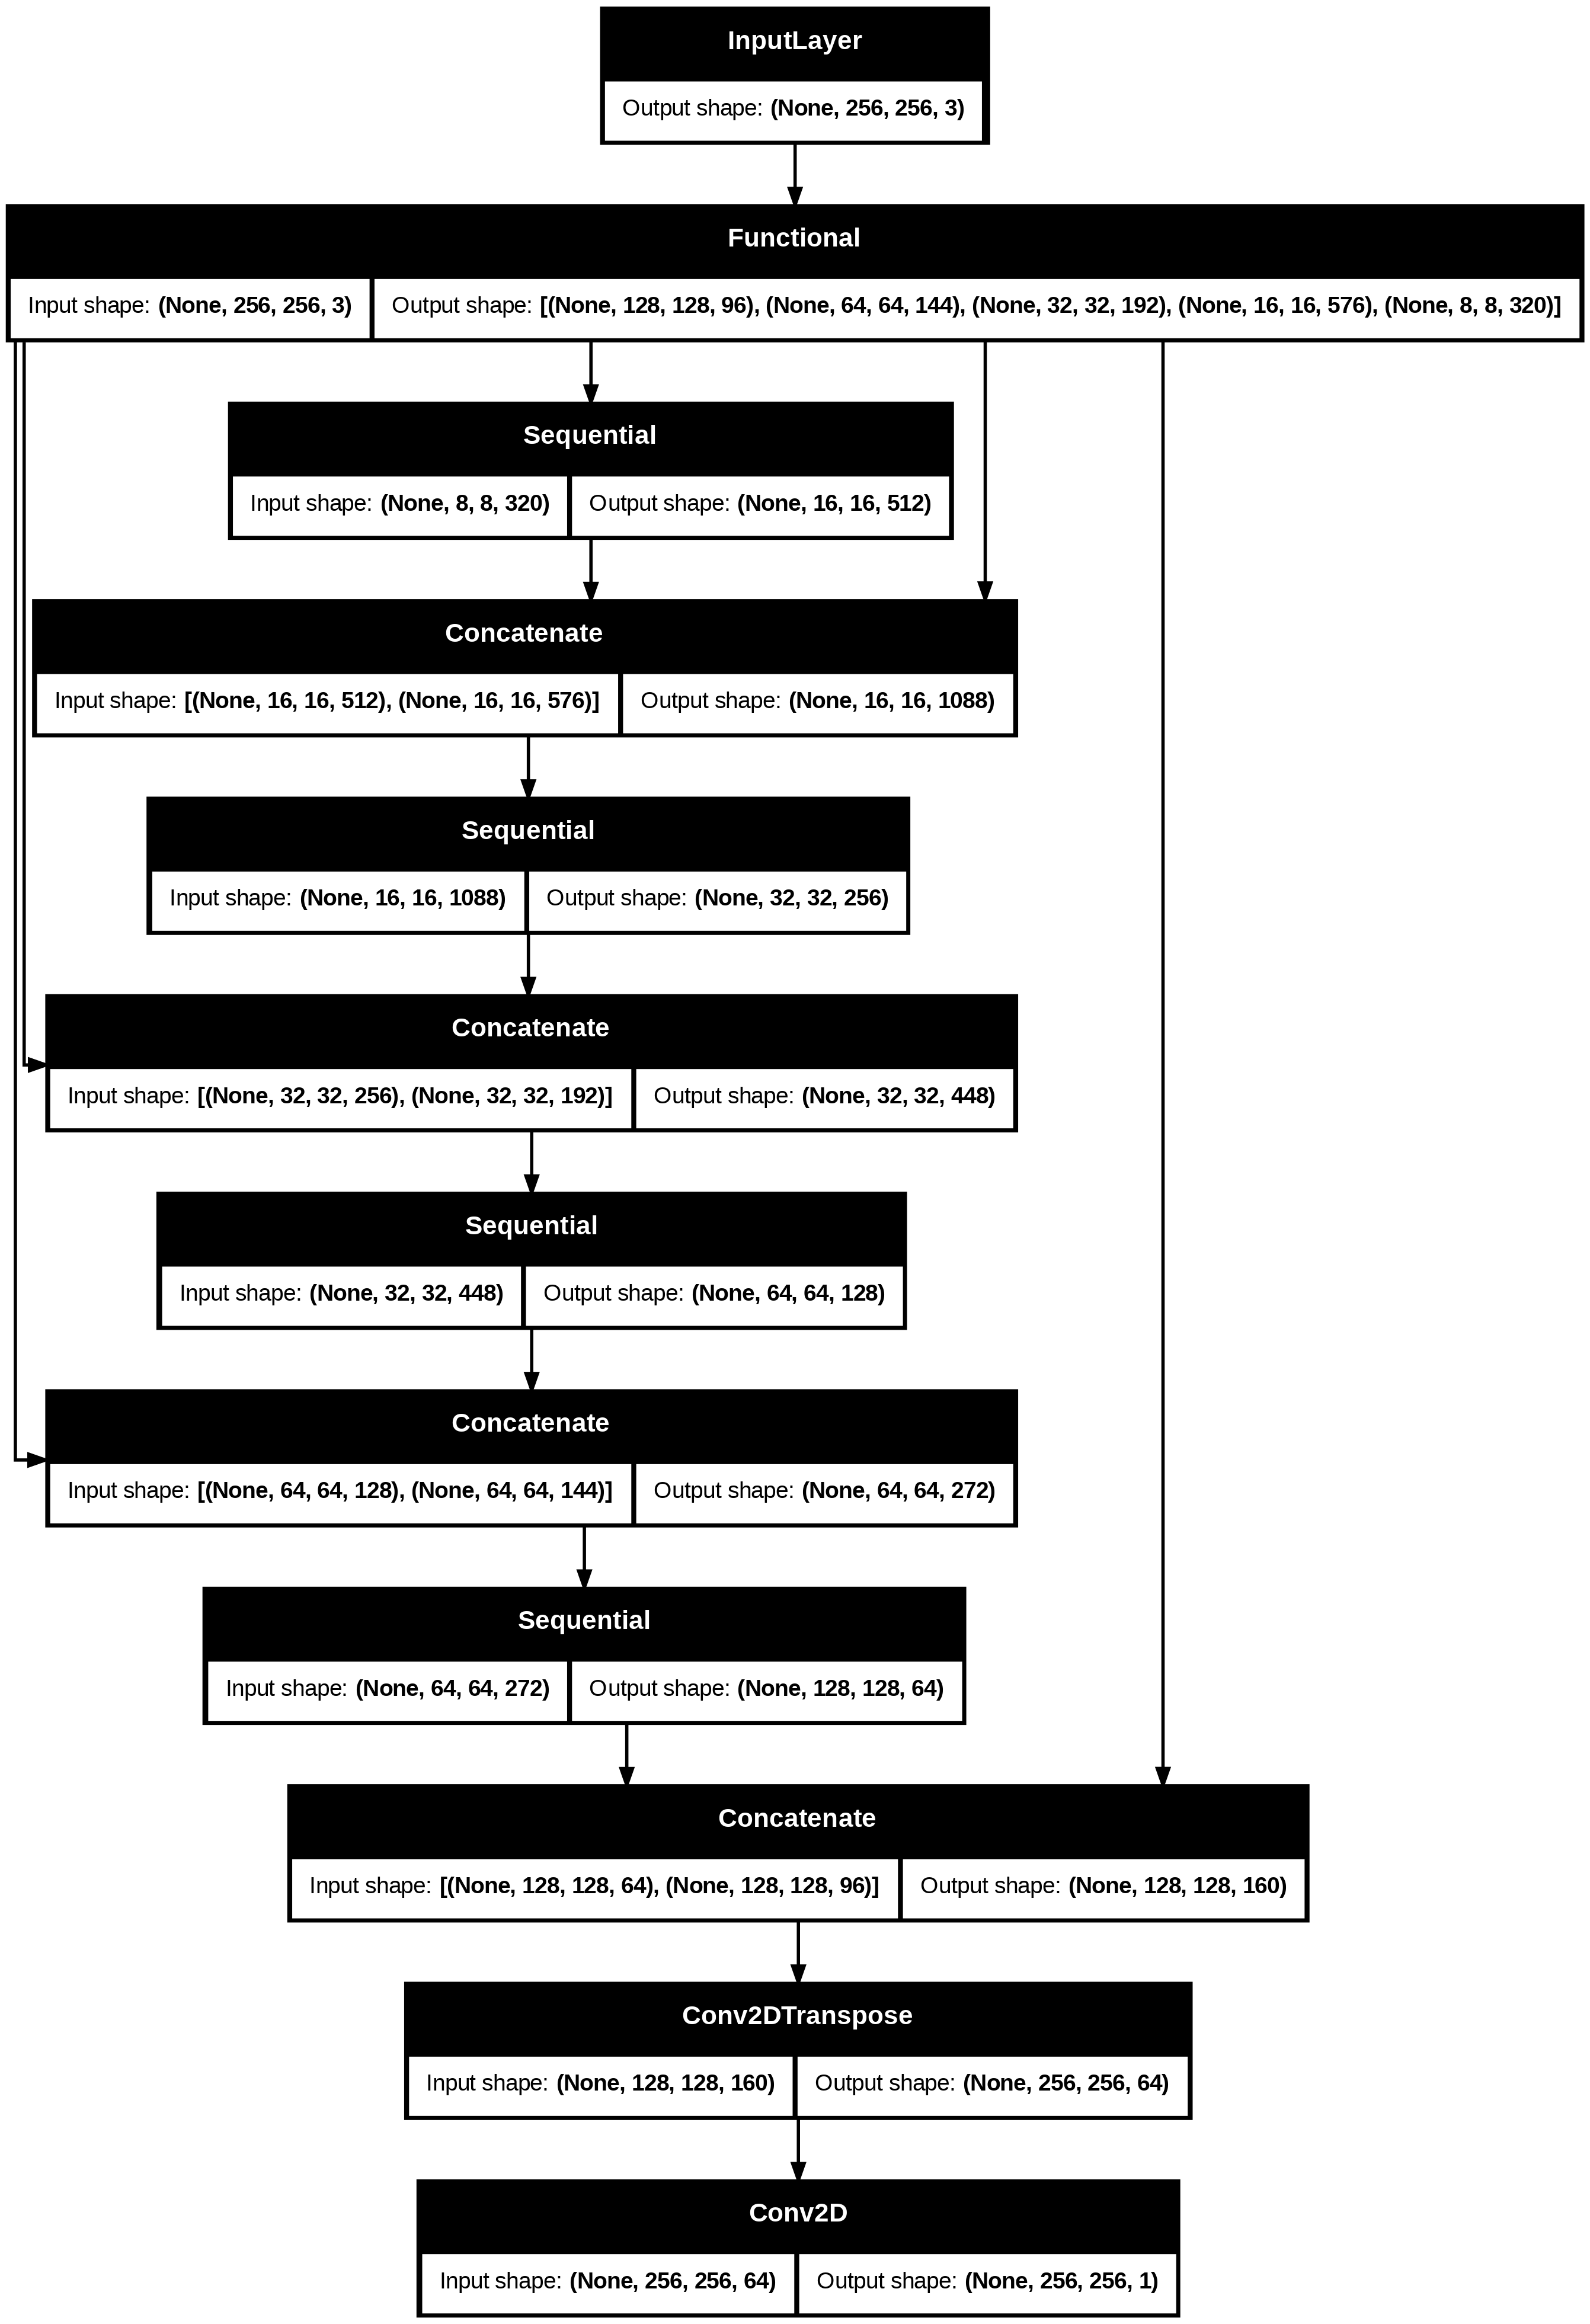

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## 訓練模型

In [ ]:
EPOCHS = 5
histories = []  # 用來存每一折的 history

for fold in range(1, NUM_FOLDS + 1):
    print(f"\n===== Fold {fold} / {NUM_FOLDS} =====")

    # 驗證集：不做增強
    val_ds = build_dataset(f"{BASE_DIR}/Fold{fold}/val",
                           f"{BASE_DIR}/Fold{fold}/valannot",
                           augment_data=False)

    # 訓練集：其他四折合併並做增強
    train_ds = None
    for k in range(1, NUM_FOLDS + 1):
        if k == fold:
            continue
        ds_k = build_dataset(f"{BASE_DIR}/Fold{k}/train",
                             f"{BASE_DIR}/Fold{k}/trainannot",
                             augment_data=True)
        train_ds = ds_k if train_ds is None else train_ds.concatenate(ds_k)

    train_ds = train_ds.shuffle(1000) \
                   .batch(BATCH_SIZE) \
                   .prefetch(AUTOTUNE)

    val_ds   = val_ds.batch(BATCH_SIZE) \
                    .prefetch(AUTOTUNE)


    callbacks = [
      EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
      ModelCheckpoint(filepath=f"best_model_fold{fold}.weights.h5",
                      monitor='val_loss',
                      save_best_only=True,
                      save_weights_only=True),
      PerClassIoUCallback(iou_metric),
    ]



    # 開始訓練
    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=EPOCHS,
      callbacks=callbacks
    )
    histories.append(history)  # 把這折的結果丟進列表


===== Fold 1 / 5 =====
Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - acc_within_0.5cm: 0.0000e+00 - acc_within_1.0cm: 0.0000e+00 - loss: 0.2985 - mean_error_cm: 0.0027 - mean_iou: 0.4343 
Epoch 1 per-class IoU:
  - 背景 (0) IoU: 0.9912
  - 前景 (1) IoU: 0.0000
72/72 ━━━━━━━━━━━━━━━━━━━━ 1097s 14s/step - acc_within_0.5cm: 0.0000e+00 - acc_within_1.0cm: 0.0000e+00 - loss: 0.2963 - mean_error_cm: 0.0026 - mean_iou: 0.4350 - val_acc_within_0.5cm: 0.0000e+00 - val_acc_within_1.0cm: 0.0000e+00 - val_loss: 0.0503 - val_mean_error_cm: 2.8541e-04 - val_mean_iou: 0.4956
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - acc_within_0.5cm: 0.4058 - acc_within_1.0cm: 0.6865 - loss: 0.0488 - mean_error_cm: 2.8868e-04 - mean_iou: 0.4996 
Epoch 2 per-class IoU:
  - 背景 (0) IoU: 0.9912
  - 前景 (1) IoU: 0.0000
72/72 ━━━━━━━━━━━━━━━━━━━━ 948s 12s/step - acc_within_0.5cm: 0.4103 - acc_within_1.0cm: 0.6904 - loss: 0.0487 - mean_error_cm: 2.8861e-04 - mean_iou: 0.4998 - val_acc_within_0.5cm: 0.0000e+00 - va

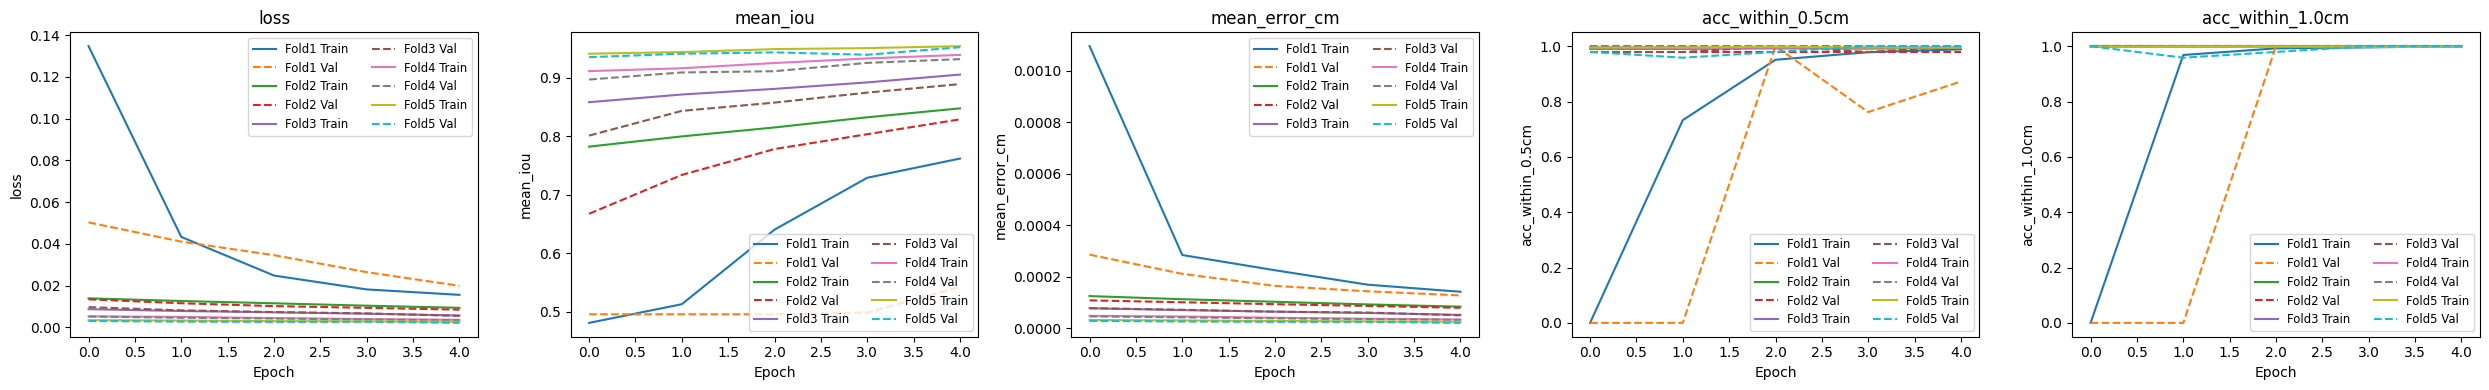

In [ ]:
metrics = ['loss','mean_iou', 'mean_error_cm', 'acc_within_0.5cm', 'acc_within_1.0cm']

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(metrics),
    figsize=(5 * len(metrics), 4)
)

for ax, m in zip(axes, metrics):
    for fold_idx, h in enumerate(histories, start=1):
        train_vals = h.history[m]              # 該折的訓練指標
        val_vals   = h.history[f'val_{m}']     # 該折的驗證指標

        # 一條實線和一條虛線，分別代表訓練和驗證
        ax.plot(h.epoch, train_vals,  label=f'Fold{fold_idx} Train')
        ax.plot(h.epoch, val_vals,   '--', label=f'Fold{fold_idx} Val')

    ax.set_title(m)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(m)
    ax.legend(fontsize='small', ncol=2)  # 讓圖例分兩行顯示，不至於擠在一起

plt.tight_layout()
plt.show()

## 做出预测

In [ ]:
def plot_batch_with_preds(image_batch, mask_batch, model, count=3):
    """
    顯示前 count 張影像的 [Input, Ground Truth, Prediction]
    - image_batch: (B, H, W, C)
    - mask_batch:  (B, H, W, 1) 或 (B, H, W)
    - model:       訓練好的 Segmentation 模型
    """
    # 1. 一次對整個 batch 做預測，得到 shape (B, H, W, 1)
    preds = model.predict(image_batch)
    # 2. 二值化預測 (threshold 0.5)
    preds = tf.where(preds >= 0.5, 1, 0)

    for i in range(min(count, image_batch.shape[0])):
        img  = image_batch[i]
        msk  = mask_batch[i]
        prd  = preds[i]

        # 如果影像是 [0,1]，把它拉回 [0,255]
        img = tf.cast(img * 255.0, tf.uint8) if tf.reduce_max(img) <= 1.0 else tf.cast(img, tf.uint8)
        # 去掉 mask/prd 的 channel 維度
        if msk.ndim == 3: msk = tf.squeeze(msk, axis=-1)
        if prd.ndim == 3: prd = tf.squeeze(prd, axis=-1)

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(img.numpy());       axs[0].set_title("Image");          axs[0].axis("off")
        axs[1].imshow(msk.numpy(), cmap="gray"); axs[1].set_title("Ground Truth"); axs[1].axis("off")
        axs[2].imshow(prd.numpy(), cmap="gray"); axs[2].set_title("Prediction");   axs[2].axis("off")
        plt.tight_layout()
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


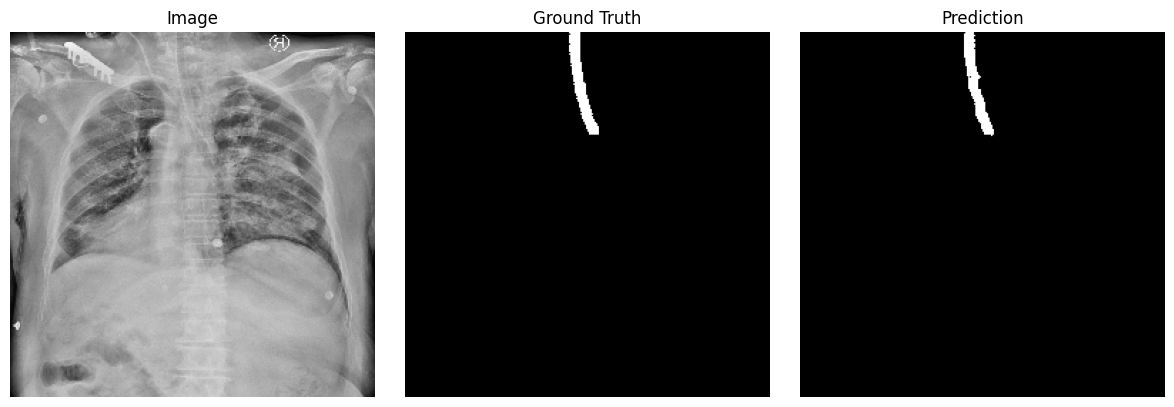

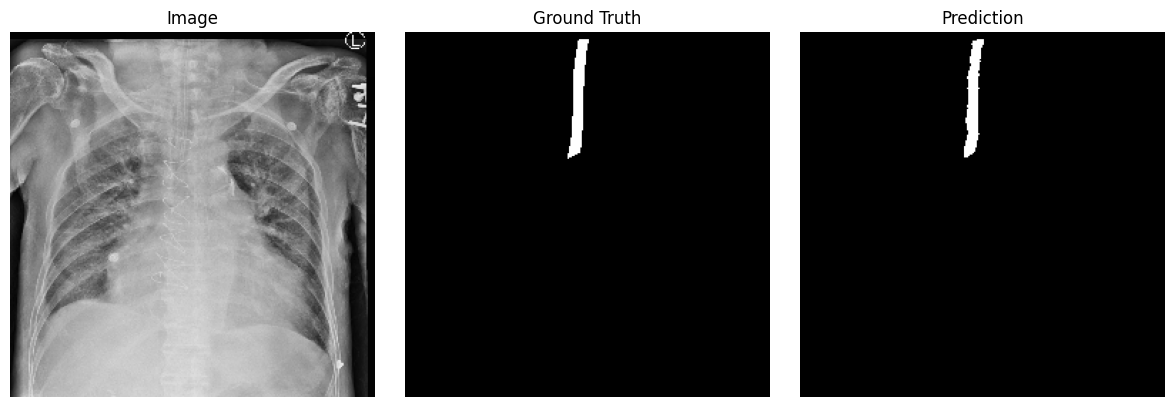

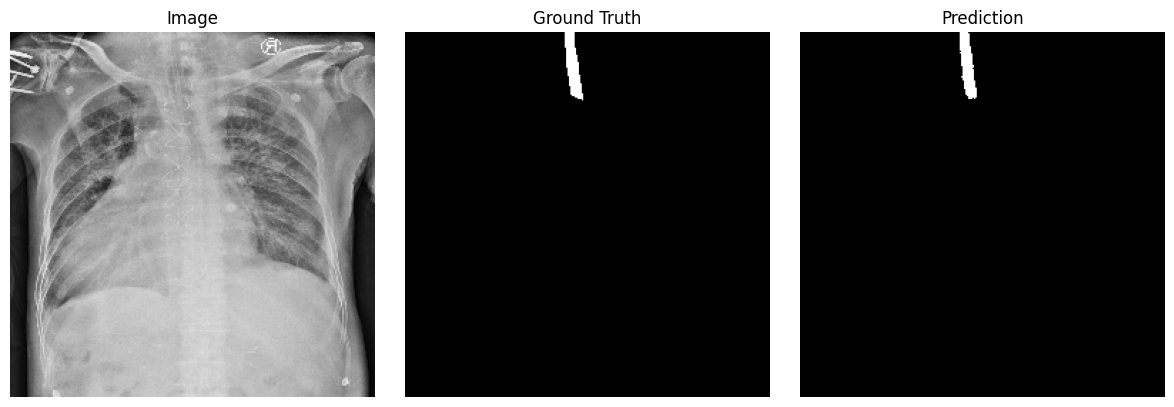

In [ ]:
test_ds = build_dataset(f"{BASE_DIR}/Fold{1}/test",
                             f"{BASE_DIR}/Fold{1}/testannot",
                             augment_data=False).batch(BATCH_SIZE)
for image_batch, mask_batch in train_ds.take(1):
    plot_batch_with_preds(image_batch, mask_batch, model, count=3)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

# ——————————————————————————————
# 1. 定義：從二值化 mask 找到 skeleton 的 endpoint
def find_endpoint(binary_mask):
    """
    binary_mask: 2D numpy array (0/1)
    回傳 (x,y)，代表 tube 最末端的像素座標
    """
    # 3x3 卷積核：中心為 0，其餘為 1
    kernel = np.array([[1,1,1],
                       [1,0,1],
                       [1,1,1]], dtype=np.uint8)
    # 計算每個像素周圍有幾個 foreground 鄰居
    nbrs = convolve(binary_mask.astype(np.uint8), kernel, mode='constant', cval=0)
    # endpoint 則是：自己是 1，且 neighbor count==1
    end_pts = np.logical_and(binary_mask==1, nbrs==1)
    ys, xs = np.where(end_pts)
    if len(xs) > 0:
        # 以下示例選擇 y 座標最大的那個點（即最靠下端）
        idx = np.argmax(ys)
        return xs[idx], ys[idx]
    else:
        # 若沒 skeleton 端點，就退而求其次：選 mask 中 y 最大的位置
        ys_all, xs_all = np.where(binary_mask==1)
        idx = np.argmax(ys_all)
        return xs_all[idx], ys_all[idx]

# ——————————————————————————————
# 2. 建資料集並分 batch
test_ds = build_dataset(
    f"{BASE_DIR}/Fold1/test",
    f"{BASE_DIR}/Fold1/testannot",
    augment_data=False
).batch(BATCH_SIZE)

# ——————————————————————————————
# 3. 逐 batch 預測並畫圖，標註端點
for image_batch, mask_batch in test_ds.take(1):
    # model.predict 回傳每個像素的機率
    pred_probs = model.predict(image_batch)

    # 我們只畫前 3 張
    for i in range(3):
        img = image_batch[i].numpy().squeeze()       # 原始影像
        gt = mask_batch[i].numpy().squeeze()          # 真實 mask
        pred = (pred_probs[i].squeeze() > 0.5).astype(np.uint8)  # 二值化預測 mask

        # 找端點
        gt_x, gt_y   = find_endpoint(gt)
        pred_x, pred_y = find_endpoint(pred)

        # 建立三欄 subplot
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        # (1) 原圖
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Image')
        axes[0].axis('off')

        # (2) Ground Truth Mask + 紅點 (G)
        axes[1].imshow(gt, cmap='viridis')
        axes[1].scatter(gt_x, gt_y, s=60, c='red', marker='o')
        axes[1].annotate('G', (gt_x, gt_y), color='white',
                         xytext=(5, -10), textcoords='offset points')
        axes[1].set_title('Ground Truth Mask')
        axes[1].axis('off')

        # (3) Predicted Mask + 黃點 (Y)
        axes[2].imshow(pred, cmap='viridis')
        axes[2].scatter(pred_x, pred_y, s=60, c='white', marker='o')
        axes[2].annotate('Y', (pred_x, pred_y), color='red',
                         xytext=(5, -10), textcoords='offset points')
        axes[2].set_title('Predicted Mask')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

NameError: name 'build_dataset' is not defined